In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn  as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
torch.manual_seed(42)

In [5]:
df = pd.read_csv("data/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
len(df)

60000

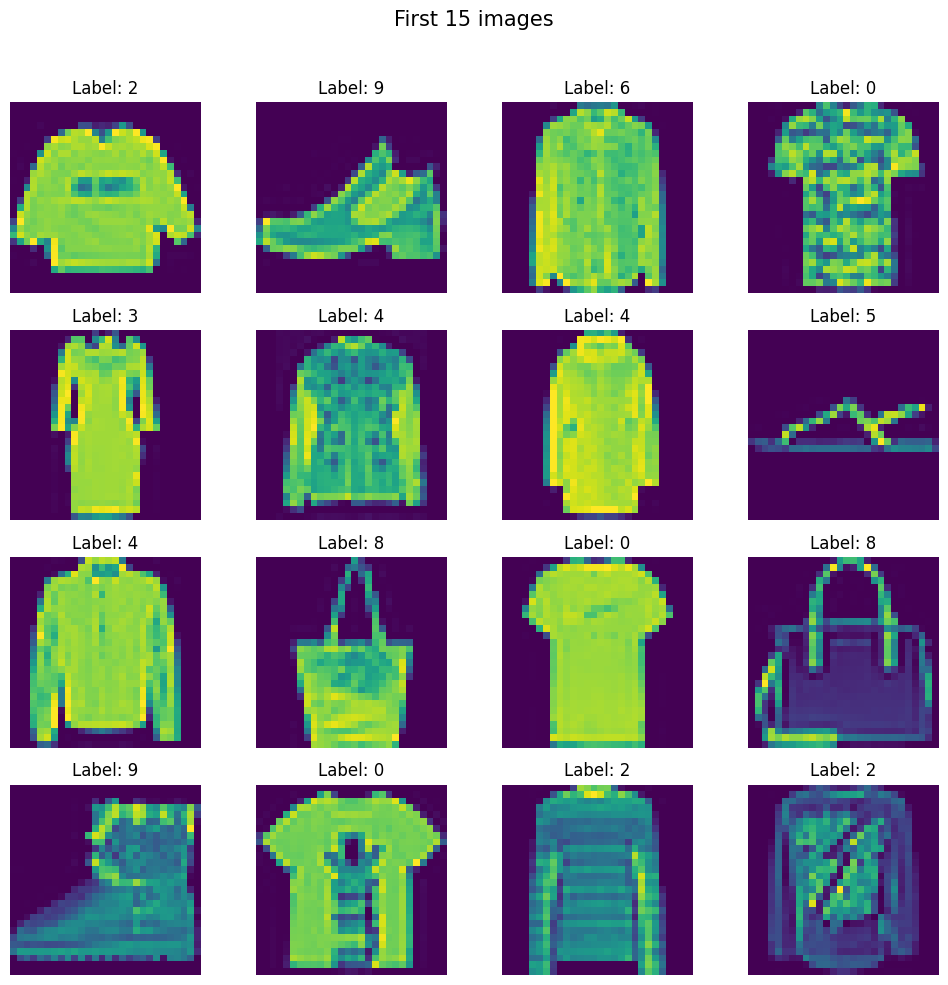

In [7]:
# create a 4x4 grid of images
fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 15 images",fontsize=15)

for i ,ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()
    

In [8]:
# train test split

X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [10]:
X_train.shape

(54000, 784)

In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

In [12]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]], shape=(54000, 784))

In [13]:
# class CustomDataset Class
class CustomDataset(Dataset):
    def __init__(self,features,labels):
        self.features = torch.tensor(features,dtype=torch.float32)
        self.labels = torch.tensor(labels,dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,index):
        return self.features[index] , self.labels[index]


In [14]:
# create train_dataset object
train_dataset = CustomDataset(X_train,y_train)

In [15]:
# create test dataset object
test_dataset = CustomDataset(X_test,y_test)

In [16]:
# define the NN class

class MyNN(nn.Module):
    def __init__(self,input_dim,output_dim,num_hidden_layers,neuron_per_layers,dropout_rate):

        super().__init__()

        layers = []

        for i in range(num_hidden_layers):
            
            layers.append(nn.Linear(input_dim,neuron_per_layers))
            layers.append(nn.BatchNorm1d(neuron_per_layers))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neuron_per_layers

        layers.append(nn.Linear(neuron_per_layers,output_dim))

        self.model = nn.Sequential(*layers)


    def forward(self,x):

        return self.model(x)

In [17]:
# objective function

def objective(trial):
    # next hyperparameter values from the search space
    num_hidden_layers = trial.suggest_int("num_hidden_layers",1,5)
    neuron_per_layers = trial.suggest_int("neuron_per_layers",8,128,step=8)

    epochs = trial.suggest_int("epochs",10,50,step=10)
    learning_rate = trial.suggest_float("learning_rate",1e-5,1e-1,log=True)

    dropout_rate = trial.suggest_float("dropout_rate",0.1,0.5,step=0.1)

    batch_size = trial.suggest_categorical("batch_size",[16,32,64,128])

    optimizer_name = trial.suggest_categorical("optimizer",['Adam','SGD','RMSprop'])

    weight_decay = trial.suggest_float("weight_decay",1e-5,1e-3,log=True)

    # create train and test loader
    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
    test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)

    # model init
    input_dim = 784
    output_dim = 10

    model = MyNN(input_dim,output_dim,num_hidden_layers,neuron_per_layers,dropout_rate)
    model.to(device)

    # optimizer selection
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    

    # training loop

    for epoch in range(epochs):

        total_epoch_loss = 0
        for batch_features,batch_labels in train_loader:

            # move data to gpu
            batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

            # forward pass
            outputs = model(batch_features)

            # calculate loss
            loss = criterion(outputs,batch_labels)


            # back pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            total_epoch_loss = total_epoch_loss + loss.item()
            

    # evaluation
    model.eval()

    total = 0
    correct = 0

    with torch.no_grad():
        for batch_features,batch_labels in test_loader:

            batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

            outputs = model(batch_features)

            _, predicted = torch.max(outputs,1)

            total = total + batch_labels.shape[0]

            correct = correct + (predicted == batch_labels).sum().item()
        
        accuracy = correct/total

    return accuracy

In [18]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2026-01-10 15:13:42,559] A new study created in memory with name: no-name-6a6c2157-0667-4675-b9ac-800c0f508830


In [19]:
study.optimize(objective,n_trials=10)

[I 2026-01-10 15:15:15,716] Trial 0 finished with value: 0.7856666666666666 and parameters: {'num_hidden_layers': 5, 'neuron_per_layers': 48, 'epochs': 30, 'learning_rate': 0.011336484475576513, 'dropout_rate': 0.4, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.00032487903086945595}. Best is trial 0 with value: 0.7856666666666666.
[I 2026-01-10 15:20:16,107] Trial 1 finished with value: 0.8926666666666667 and parameters: {'num_hidden_layers': 4, 'neuron_per_layers': 112, 'epochs': 20, 'learning_rate': 0.001129758521950577, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 1.1336680113759215e-05}. Best is trial 1 with value: 0.8926666666666667.
[I 2026-01-10 15:22:20,467] Trial 2 finished with value: 0.8521666666666666 and parameters: {'num_hidden_layers': 2, 'neuron_per_layers': 72, 'epochs': 40, 'learning_rate': 0.005311960705806428, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 2.1594933648115245e-05}. Best is tri

In [43]:
study.best_value

0.8926666666666667

In [44]:
study.best_params

{'num_hidden_layers': 4,
 'neuron_per_layers': 72,
 'epochs': 50,
 'learning_rate': 0.00035448863979203947,
 'dropout_rate': 0.2,
 'batch_size': 16,
 'optimizer': 'Adam',
 'weight_decay': 0.00010335715680565133}